<a href="https://colab.research.google.com/github/ImIm20/portfolio/blob/main/Image_Classification_Rock%2C_Paper_and_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nama : Imroatus Sholihah

This notebook was made for the final project of the Introduction to Machine Learning course by dicoding. the purpose of this notebook is to make image classification using CNN. at the end of this notebook we can input an image and the model will predict whether it is rock, paper or scissors.

#Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
#checking tensorflow version
print(tf.__version__)

2.5.0


In [ ]:
#downloading the dataset
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
-O rockpaperscissors.zip

--2021-07-16 14:01:33--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  8.92MB/s    in 26s     

2021-07-16 14:01:59 (11.9 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
# melakukan ekstraksi pada file zip ke dalam folder 'tmp'
import zipfile,os
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

# Membagi Dataset
dataset akan dibagi menjadi train dan validation dengan rasio 6:4

In [ ]:
!pip install split_folders

In [ ]:
#membuat folder baru yg berisi dataset di direktori 'tmp/rockpaperscissors/data' untuk membagi data dengan rasio 6:4
import splitfolders
splitfolders.ratio('tmp/rockpaperscissors/rps-cv-images', 'tmp/rockpaperscissors/data', seed=1, ratio=(.6, .4))

Copying files: 2188 files [00:00, 3650.87 files/s]


In [ ]:
base_dir = 'tmp/rockpaperscissors/data' #direktori dataset yg sudah dibagi dg rasio 6:4
train_dir = os.path.join(base_dir, 'train') #membuat variable yg beerisi data latih
validation_dir = os.path.join(base_dir, 'val') #membuat variable yg brisi data validasi
print(os.listdir('tmp/rockpaperscissors/data/train')) #menampilkan folder yg ada di dalam folder train
print(os.listdir('tmp/rockpaperscissors/data/val')) #menampilkan folder yg ada di dalam folder val

['rock', 'scissors', 'paper']
['rock', 'scissors', 'paper']


In [ ]:
train_rock_dir = os.path.join(train_dir, 'rock') #membuat variable yg berisi data latih rock
train_scissors_dir = os.path.join(train_dir, 'scissors') #membuat variable yg berisi data latih scissors
train_paper_dir = os.path.join(train_dir, 'paper') #membuat variable yg berisi data latih paper
 
validation_rock_dir = os.path.join(validation_dir, 'rock') #membuat variable yg berisi data validasi rock
validation_scissors_dir = os.path.join(validation_dir, 'scissors') #membuat variable yg berisi data validasi scissor
validation_paper_dir = os.path.join(validation_dir, 'paper') #membuat variable yg berisi data validasi paper

## Melakukan Augmentasi Gambar dengan ImageDataGenerator
Image data generator adalah fungsi yang berguna untuk mempersiapkan data latih dan data testing yang akan diberikan ke model. Salah satu kemudahannya adalah untuk augmentasi gambar. Augmentasi gambar adalah teknik untuk menciptakan data-data baru dari data yang telah ada. Contoh augmentasi gambar adalah horizontal flip di mana gambar akan dibalikkan secara horizontal. Selain itu Image data generator dapat secara otomatis melabeli sebuah gambar sesuai dengan direktori di mana ia disimpan.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#membuat objek ImageDataGenerator untuk augmentasi gambar
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest'
                                  )
     
validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest'
                                    )

In [ ]:
# Menggunakan Objek image data generator sebelumnya untuk mempersiapkan data latih yang akan dipelajari oleh model.
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical', #karena ini merupakan klasifikasi 3 kelas
                                                    target_size=(60, 90) #ubah resolusi gambar menjadi 150px x 100px
                                                   )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(60, 90)
                                                    )


Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# Membuat Model
Model sequential pada keras adalah tumpukan layer-layer, yang sama seperti pada sebuah MLP. Perbedaan dari CNN dan MLP hanya pada terdapatnya 2 lapis layer konvolusi dan max pooling. fungsi dari layer konvolusi adalah untuk mengekstraksi atribut pada gambar. Sedangkan layer max pooling berguna untuk mereduksi resolusi gambar sehingga proses pelatihan CNN lebih cepat.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), activation=tf.nn.relu,input_shape=(60, 90, 3)), #input layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu,padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu,padding = 'Same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    
    #hidden layer, jumlah perceptron 256 dengan fungsi aktivasi relu
    tf.keras.layers.Dense(256, activation=tf.nn.relu), 
    
    #output layer, fungsi aktivasi softmax karena ada 3 kelas. softmax akan memilih yg probabilitinya paling besar
    tf.keras.layers.Dense(3, activation = tf.nn.softmax) 
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 56, 86, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 86, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 86, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 43, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 43, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 21, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 37632)            

ReduceLROnPlateau ini memonitor sebuah kuantitas dan jika tidak ada perbaikan/pembaruan dari parameter yang terlihat untuk sejumlah 'patience' dari epoch, maka learning rate akan berkurang.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)



Lakukan compile pada model dan tentukan loss function serta optimizer pada CNN. Loss function bisa menggunakan categorical_crossentropy karena data terdiri dari 3 label/kelas. Optimizer menggunakan Adam. Kita dapat melatih model kita menggunakan metode fit. 

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer= tf.keras.optimizers.Adam(), 
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs = 20,
                    verbose = 1,
                    validation_data = validation_generator,
                    callbacks=[learning_rate_reduction])


Epoch 1/20
41/41 [==============================] - 82s 2s/step - loss: 1.4463 - acc: 0.4489 - val_loss: 1.0967 - val_acc: 0.3322
Epoch 2/20
41/41 [==============================] - 81s 2s/step - loss: 0.6070 - acc: 0.7553 - val_loss: 1.0819 - val_acc: 0.3368
Epoch 3/20
41/41 [==============================] - 81s 2s/step - loss: 0.3167 - acc: 0.8834 - val_loss: 0.9334 - val_acc: 0.6724
Epoch 4/20
41/41 [==============================] - 81s 2s/step - loss: 0.2106 - acc: 0.9245 - val_loss: 0.8862 - val_acc: 0.5765
Epoch 5/20
41/41 [==============================] - 80s 2s/step - loss: 0.1546 - acc: 0.9466 - val_loss: 0.5484 - val_acc: 0.8950
Epoch 6/20
41/41 [==============================] - 80s 2s/step - loss: 0.1811 - acc: 0.9367 - val_loss: 0.6171 - val_acc: 0.8276
Epoch 7/20
41/41 [==============================] - 80s 2s/step - loss: 0.0940 - acc: 0.9672 - val_loss: 0.4429 - val_acc: 0.8721

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/2

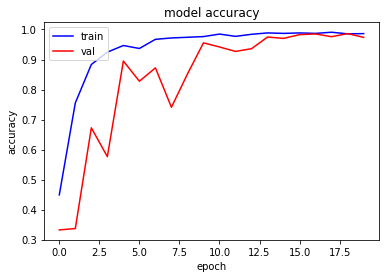

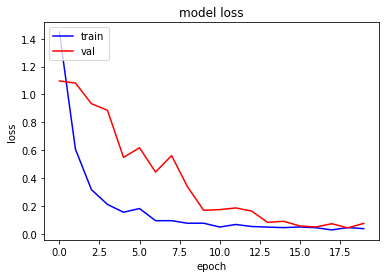

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Saving 0NDYNEoDui7o64gU.png to 0NDYNEoDui7o64gU.png
0NDYNEoDui7o64gU.png
rock


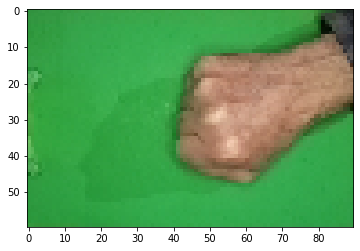

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(60,90))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(path)
  if classes[0][0]==1:
    print("paper")
  elif classes[0][1]==1:
    print("rock")
  elif classes[0][2]==1:
    print("Scissors")

Saving punggung-tangan-perempuan.jpeg to punggung-tangan-perempuan (1).jpeg
punggung-tangan-perempuan.jpeg
paper


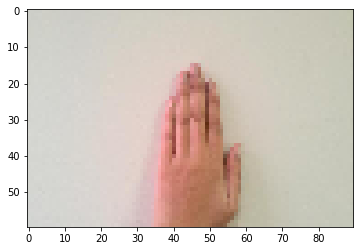

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(60,90))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(path)
  if classes[0][0]==1:
    print("paper")
  elif classes[0][1]==1:
    print("rock")
  elif classes[0][2]==1:
    print("Scissors")

Saving 1WX9KKoq0nkWiTxI.png to 1WX9KKoq0nkWiTxI.png
1WX9KKoq0nkWiTxI.png
Scissors


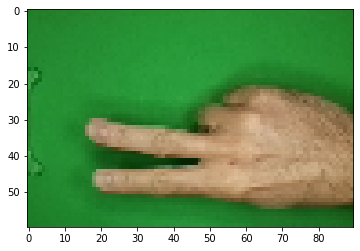

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(60,90))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(path)
  if classes[0][0]==1:
    print("paper")
  elif classes[0][1]==1:
    print("rock")
  elif classes[0][2]==1:
    print("Scissors")